### [The Winton Stock Market Challenge](https://www.kaggle.com/c/the-winton-stock-market-challenge)

In this recruiting competition, Winton challenges you to take on the very difficult task of predicting the future (stock returns). Given historical stock performance and a host of masked features, can you predict intra and end of day returns without being deceived by all the noise? 

In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window.

In [1]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pylab as pl


%matplotlib inline   

pd.__version__

u'0.17.0'

### File descriptions

* [train.csv](https://www.kaggle.com/c/the-winton-stock-market-challenge/download/train.csv.zip) - the training set, including the columns of:
  *  Feature_1 - Feature_25
  *  Ret_MinusTwo, Ret_MinusOne
  *  Ret_2 - Ret_120
  * Ret_121 - Ret_180: target variables
  * Ret_PlusOne, Ret_PlusTwo: target variables
  * Weight_Intraday, Weight_Daily


* [test.csv](https://www.kaggle.com/c/the-winton-stock-market-challenge/download/test.csv.zip) - the test set, including the columns of:
  * Feature_1 - Feature_25
  * Ret_MinusTwo, Ret_MinusOne
  * Ret_2 - Ret_120


* [sample_submission.csv](https://www.kaggle.com/c/the-winton-stock-market-challenge/download/sample_submission.csv.zip) - a sample submission file in the correct format


In [2]:
train = pd.read_csv('C:/Users/sth/Downloads/train.csv/train.csv')
sample_submission = pd.read_csv('C:/Users/sth/Downloads/sample_submission.csv/sample_submission.csv')

### Training Set Data fields

```40,000 rows by 211 columns with 25 features, 180 one minutes returns, 4 daily returns and 2 weights```

* **Feature_1 to Feature_25**: different features relevant to prediction
* **Ret_MinusTwo**:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
* **Ret_MinusOne**: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
* **Ret_2 to Ret_120**: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
* **Ret_121 to Ret_180**: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 
* **Ret_PlusOne**: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1 day). This is a target variable you need to predict as {id}_61. 
* **Ret_PlusTwo**: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable you need to predict as {id}_62. 
* **Weight_Intraday**: weight used to evaluate intraday return predictions Ret 2 to 120 and Ret 121 to 180
* **Weight_Daily**: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

In [3]:
def data(ds=train):

    #IDs run from 1 to len(ds); note not zero based
    ids =  ds.iloc[0:,0]

    ##features only, all rows (Ids)
    features = ds.iloc[0:,1:26]

    #daily returns two days prior and one day prior
    Ret_MinusTwo = ds.iloc[0:,26]
    Ret_MinusOne = ds.iloc[0:,27]

    if len(ds)==4e4:
        #intraday minute returns; 180 minutes
        Ret_Intraday = ds.iloc[0:,28:207]

        #daily returns next day, two days after
        Ret_PlusOne = ds.iloc[0:,207]
        Ret_PlusTwo = ds.iloc[0:,208]

        ##handy dataframe of all 4 daily returns
        dailyReturns = ds.iloc[0:,[26,27,207,208]]

        #weights, intraday and daily
        Weight_Intraday  =  ds.iloc[0:,209]
        Weight_Daily       =  ds.iloc[0:,210]

        ##handy dataframe of both weights
        weights=pd.concat([Weight_Daily.to_frame('Daily'),Weight_Intraday.to_frame('Intraday')])
    else:
        #intraday minute returns; 120 minutes
        Ret_Intraday = ds.iloc[0:,28:147]

        ##handy dataframe of both prior daily returns
        dailyReturns = ds.iloc[0:,[26,27]]

        ##placeholder
        weights = pd.DataFrame()
        
        
    return features, dailyReturns, weights, Ret_Intraday

In [4]:
##pass either train or test to data function
features, dailyReturns, weights, Ret_Intraday = data(train)

In [5]:
#print train.dtypes
pd.set_option('display.max_columns', 25)
features.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
count,6687.000000,30854.000000,38763.000000,32279.000000,40000.000000,38067.000000,40000.000000,39531.000000,38125.000000,20529.000000,39013.000000,38904.000000,39406.000000,39272.000000,37859.000000,39390.000000,39354.000000,39432.000000,38810.000000,32174.000000,38982.000000,38655.000000,38289.000000,39274.000000,39345.000000
mean,3.590250,-0.117558,0.558392,0.405572,5.482775,0.430972,49244.971525,0.196958,10.680289,4.744703,-0.572244,0.498508,4.238162,1.588524,3.891381,1.007362,-0.549725,0.803059,-1.205438,5.267359,0.605593,-0.773089,0.799833,-1.209290,-0.329675
std,2.798532,1.236250,0.902233,0.799082,2.942324,1.498274,28242.409717,0.138485,2.850634,0.865096,1.246347,0.351855,2.570493,0.316907,5.035073,0.085488,0.936833,1.165442,0.642426,2.549227,1.319158,1.389229,1.288040,1.739656,0.958661
min,1.000000,-3.440521,-4.643526,-5.440596,1.000000,-0.936644,338.000000,0.009800,0.000000,1.000000,-7.359120,0.000000,0.000000,-0.149272,0.021679,1.000000,-2.613987,-5.758047,-3.292909,2.000000,-1.514998,-5.819912,-7.221387,-11.442205,-1.903876
25%,1.000000,-0.967186,-0.110192,-0.111696,2.000000,-0.265555,26143.000000,0.016600,9.000000,5.000000,-1.115527,0.140000,2.000000,1.415236,0.340081,1.000000,-1.021216,0.057598,-1.619718,3.000000,-0.294925,-1.787615,0.539979,-1.838688,-0.830749
50%,3.000000,-0.389162,0.437228,0.403516,6.000000,0.055564,48457.000000,0.213800,11.000000,5.000000,-0.324923,0.500000,4.000000,1.611754,1.292008,1.000000,-0.599050,0.587005,-1.169327,5.000000,0.308468,-0.699112,0.962580,-0.868435,-0.551550
75%,6.000000,0.414442,1.064754,0.945944,8.000000,0.559921,72387.000000,0.331800,12.000000,5.000000,0.323631,0.850000,6.000000,1.782934,6.357561,1.000000,-0.184854,1.321231,-0.735786,7.000000,1.109743,0.282958,1.415303,-0.129465,-0.257543
max,10.000000,4.175150,4.530405,2.953163,10.000000,12.609885,99861.000000,0.365000,36.000000,6.000000,1.786886,1.000000,9.000000,3.161848,28.018114,2.000000,7.683857,6.352352,0.898236,10.000000,7.737020,2.284991,3.228906,2.526654,4.020332


##### features 

* 1, 5, 10, 13, 16, 20 are categorical integers with range in (1,10) maybe 11 for feature 20
* 8 categorical floats with range = (0.0,0.35)
* 9 categorical ints with range(0,36) guassian distributed
* 16 constant (=1) except for where it isn't (=2)
* 2, 25 bimodal
* 12 looks like intraday liquidity "smile"
* 4,14 guassian


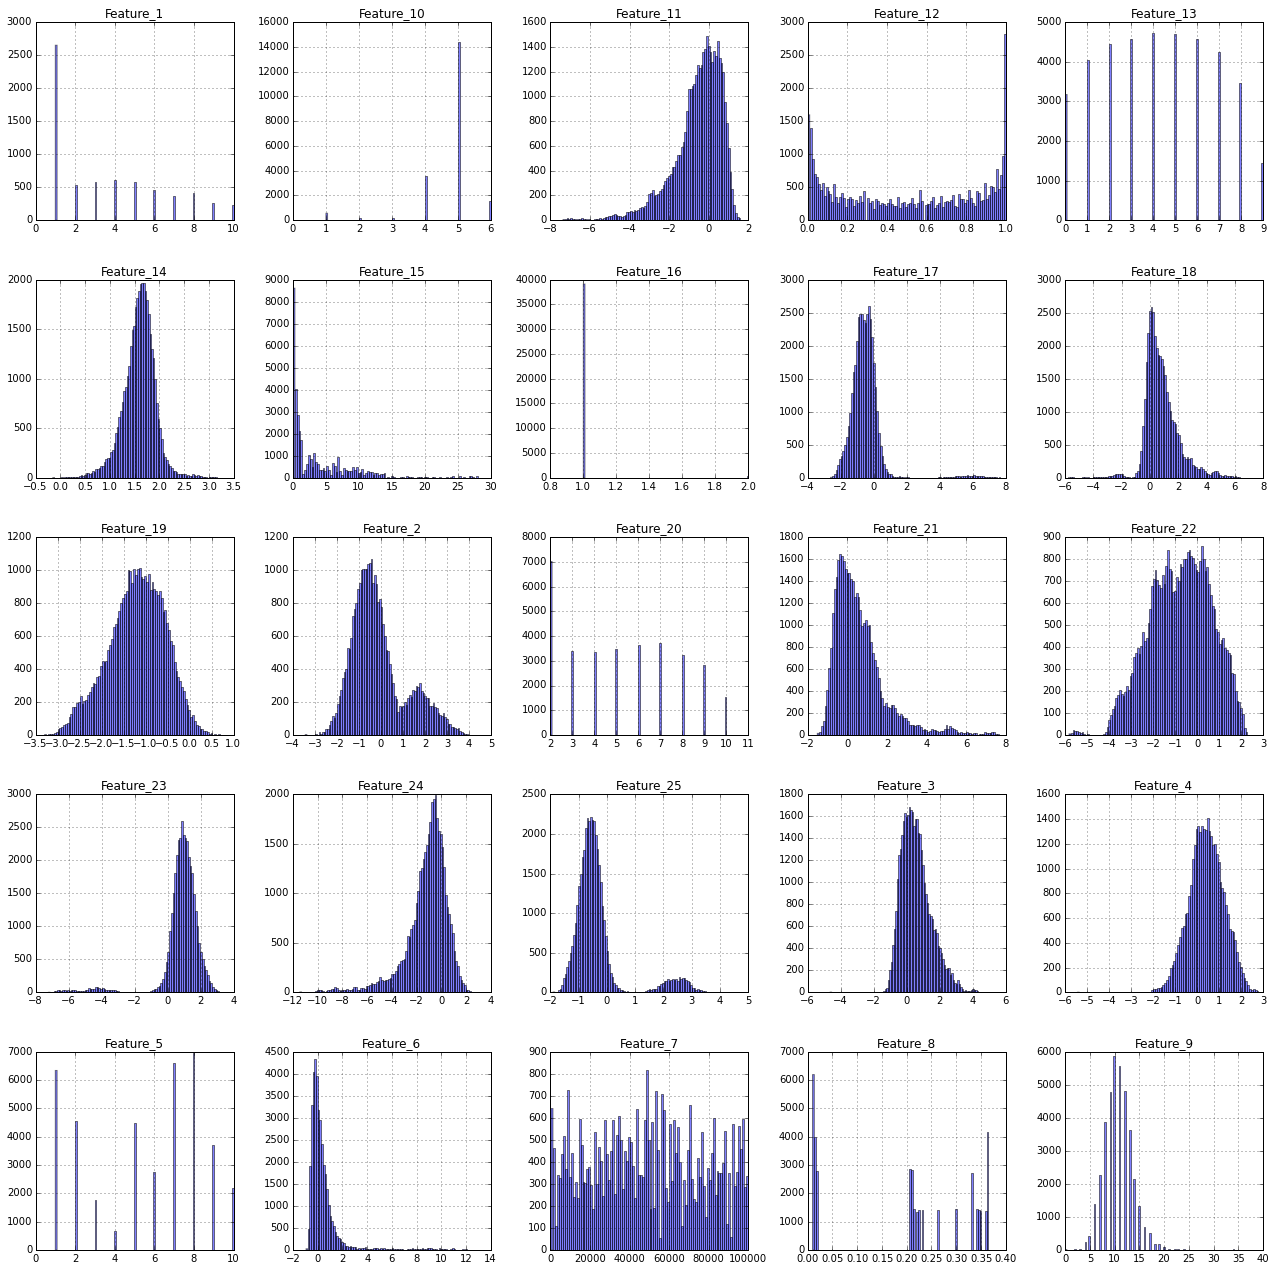

In [6]:
features.hist(alpha=0.5, bins=100,figsize=(22,22));

In [7]:
##Why are a very few (290 == 2, 610 == NaN) of Feature_16 equal to 2 or NaN?
features['Feature_16'].value_counts()

1    39100
2      290
Name: Feature_16, dtype: int64

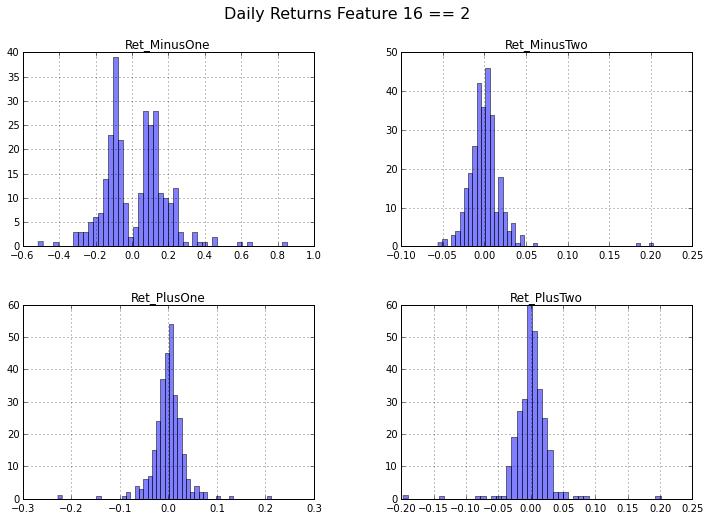

In [8]:
##NB Ret_MinusOne filtered by Feature_16 has abnormally low -0- occurrences
axes=dailyReturns[features['Feature_16']==2].hist(alpha=0.5,bins=50,figsize=(12,8));
pl.suptitle("Daily Returns Feature 16 == 2",fontsize=16);

,LOGmeans,LOGstd,means,std
Ret_MinusTwo,0.000389,0.028106,0.000784,0.028278
Ret_MinusOne,-0.001267,0.030512,-0.000803,0.030569
Ret_PlusOne,-0.000524,0.025176,-0.000210,0.025038
Ret_PlusTwo,-0.000283,0.024413,0.000012,0.024160


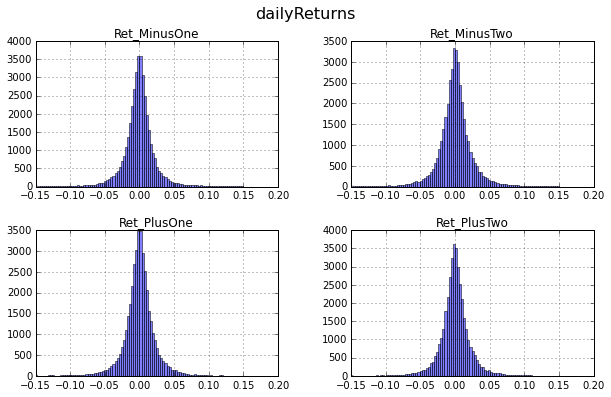

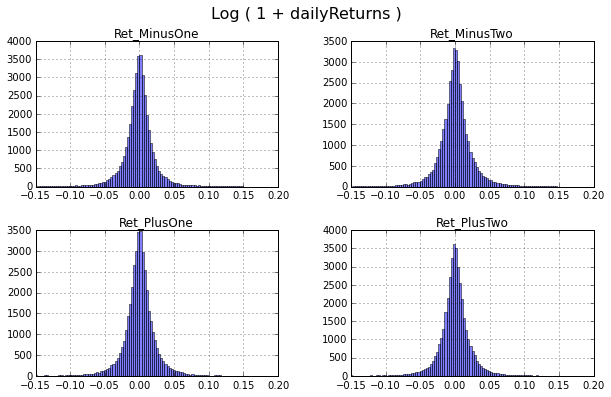

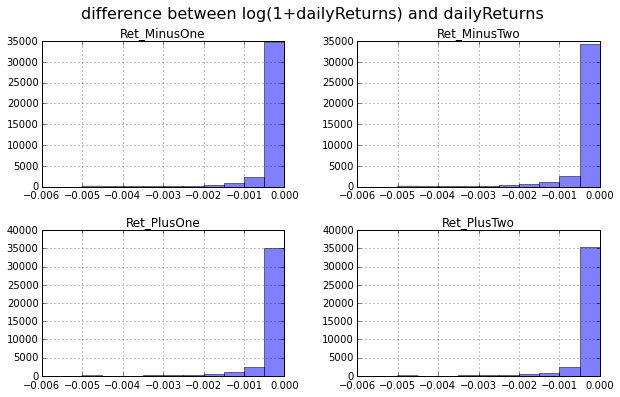

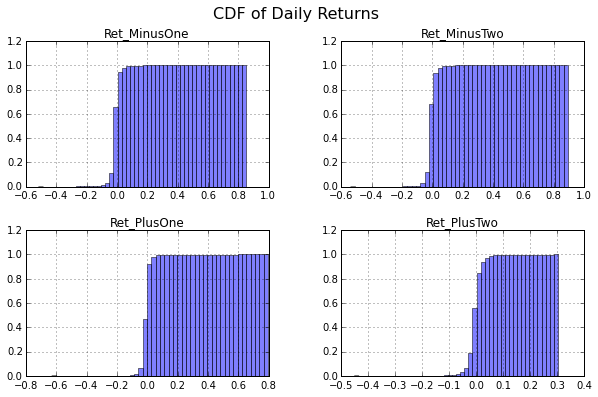

In [9]:
axes=(dailyReturns).hist(alpha=0.5, bins=100, range=(-0.15,0.15),figsize=(10,6));
pl.suptitle("dailyReturns",fontsize=16)

axes=np.log(1+dailyReturns).hist(alpha=0.5, bins=100, range=(-0.15,0.15),figsize=(10,6));
pl.suptitle("Log ( 1 + dailyReturns )",fontsize=16)

(np.log(1+dailyReturns) - dailyReturns).hist(alpha=0.5, range=(-0.005,0),figsize=(10,6));
pl.suptitle("difference between log(1+dailyReturns) and dailyReturns",fontsize=16)

(dailyReturns).hist(alpha=0.5,figsize=(10,6),bins=50,normed=True,cumulative=True);
pl.suptitle("CDF of Daily Returns",fontsize=16)


pd.DataFrame( { 'means' : np.mean(dailyReturns),  'std' : np.std(dailyReturns),  'LOGmeans' : np.mean(np.log(1+dailyReturns)),  'LOGstd' : np.std(np.log(1+dailyReturns) ) } )


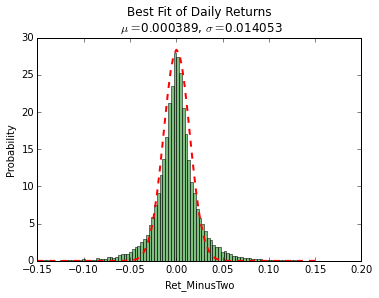

In [10]:
mu = 0.000389 #0.000784  # mean of distribution
##why better fit for sigma/2?
sigma = (0.028106)/2.0 #(0.028278)/2  # standard deviation of distribution
x = mu + sigma * np.random.randn(40000)

# add a 'best fit' line
#(dailyReturns['Ret_MinusTwo']).hist(alpha=0.5,figsize=(10,6),bins=50,normed=True,range=(-0.15,0.15));
#pl.suptitle("Best Fit of Daily Returns",fontsize=16)

num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(np.log(1+dailyReturns['Ret_MinusTwo']), num_bins, normed=1, facecolor='green', alpha=0.5, range=(-0.15,0.15))
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2)
plt.xlabel('Ret_MinusTwo')
plt.ylabel('Probability')
plt.title('Best Fit of Daily Returns\n $\mu=$'+str(mu)+', ' +'$\sigma=$'+str(sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()


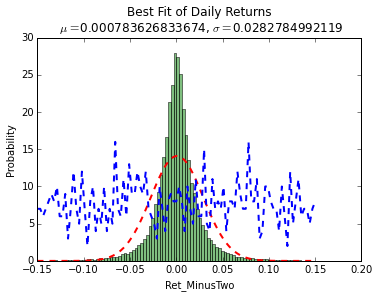

In [535]:
rets = dailyReturns['Ret_MinusTwo']

mu = np.mean(rets)  # mean of distribution
sigma = np.std(rets)   # standard deviation of distribution
x = mu + sigma * np.random.randn(40000)



num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(rets,num_bins, normed=1, facecolor='green', alpha=0.5, range=(-0.15,0.15))
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2)

_lambda = 8
s = np.random.poisson(_lambda, len(bins))
plt.plot(bins, s, 'b--',linewidth=2)

plt.xlabel('Ret_MinusTwo')
plt.ylabel('Probability')
plt.title('Best Fit of Daily Returns\n $\mu=$'+str(mu)+', ' +'$\sigma=$'+str(sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()


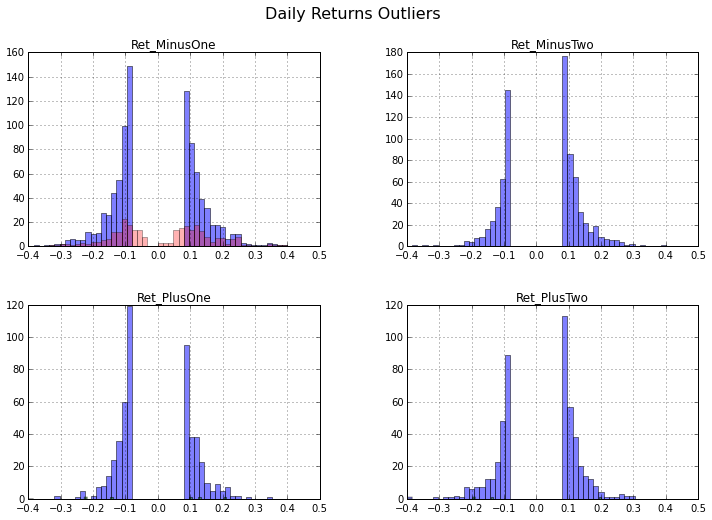

In [139]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,8))
dailyReturns[abs(dailyReturns)>0.08].hist(alpha=0.5,bins=50,ax=axes,range=(-.4,.4));
pl.suptitle("Daily Returns Outliers",fontsize=16);
#plt.hist(dailyReturns['Ret_MinusOne'][features['Feature_16']==2],alpha=0.5,bins=50,color='green');
dailyReturns[(features['Feature_16']==2)][(abs(dailyReturns)>0)]['Ret_MinusOne'].hist(alpha=0.3,bins=50,color='red',ax=axes[0,0],range=(-.4,.4));
dailyReturns[(features['Feature_16']==2)][(abs(dailyReturns)>0.1)]['Ret_MinusTwo'].hist(alpha=0.5,bins=50,color='green',ax=axes[0,1]);
dailyReturns[(features['Feature_16']==2)][(abs(dailyReturns)>0.1)]['Ret_PlusOne'].hist(alpha=0.5,bins=50,color='green',ax=axes[1,0]);
dailyReturns[(features['Feature_16']==2)][(abs(dailyReturns)>0.1)]['Ret_PlusTwo'].hist(alpha=0.5,bins=50,color='green',ax=axes[1,1]);


#### Feature 16 and outliers in Ret_MinusOne

Feature 16 == 2 corresponds to many of the outliers of Ret)MinusOne, but as seen above not of the other three daily returns.  If Feature 16 == 2 and outlier in Ret_MinusOne THEN not an outlier in Ret_PlusOne and Ret_PlusTwo?

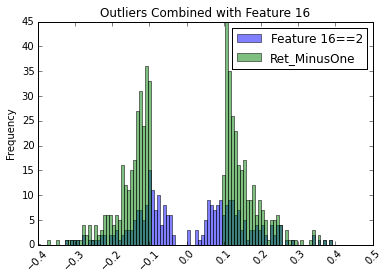

In [154]:
pd.DataFrame({'Ret_MinusOne':dailyReturns['Ret_MinusOne'][abs(dailyReturns['Ret_MinusOne'])>0.10],
              'Feature 16==2':dailyReturns['Ret_MinusOne'][features['Feature_16']==2]}).plot(kind='hist',
                                                                                             alpha=0.5,bins=100,rot=45,
                                                                                             title='Outliers Combined with Feature 16',
                                                                                             range=(-0.4,0.4)
                                                                                            );

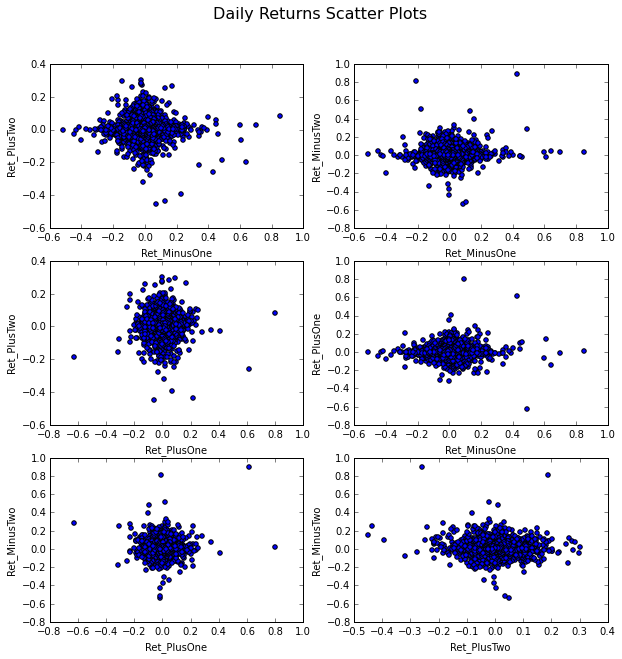

In [22]:
##Daily returns scatter plots, day to day
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
plt.suptitle("Daily Returns Scatter Plots",fontsize=16);
dailyReturns.plot(kind="scatter",x='Ret_MinusOne',y='Ret_PlusTwo',ax=axes[0,0]);
dailyReturns.plot(kind="scatter",x='Ret_MinusOne',y='Ret_MinusTwo',ax=axes[0,1]);
dailyReturns.plot(kind="scatter",x='Ret_MinusOne',y='Ret_PlusOne',ax=axes[1,1]);
dailyReturns.plot(kind="scatter",x='Ret_PlusOne',y='Ret_PlusTwo',ax=axes[1,0]);
dailyReturns.plot(kind="scatter",x='Ret_PlusOne',y='Ret_MinusTwo',ax=axes[2,0]);
dailyReturns.plot(kind="scatter",x='Ret_PlusTwo',y='Ret_MinusTwo',ax=axes[2,1]);



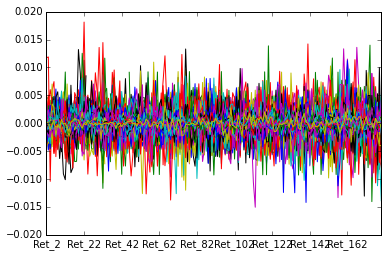

In [23]:
##First thousand "stocks" intraday returns minute by minute
##missing data as NaN
#with pd.plot_params.use('x_compat', True):
Ret_Intraday.iloc[0:1000,:].transpose().plot(legend=None);

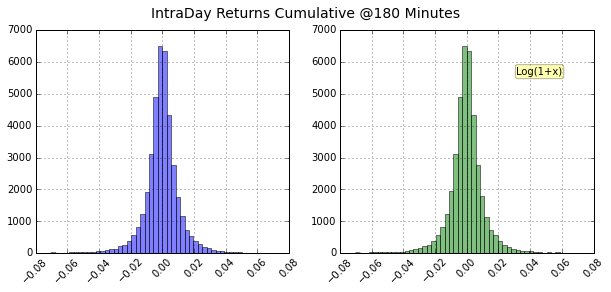

In [24]:
irets = Ret_Intraday.transpose()
rets = irets.cumsum()
x      = float(rets.loc['Ret_180'][9000])
logx = np.log(1+x)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
plt.suptitle("IntraDay Returns Cumulative @180 Minutes",fontsize=14)

#plt.annotate('{0:2.4f}'.format(x), xy=(x, 5000), xytext=(-20,20), 
#            textcoords='offset points', ha='center', va='bottom',
#            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
#                            color='red'))
rets.loc['Ret_180'].hist(bins=50,range=(-0.07,0.07),alpha=0.5,xrot=45,ax=axes[0]);

#plt.annotate('Log(1+{0:2.4f})'.format(float(x)), xy=(logx, 5000), xytext=(-20,20), 
#            textcoords='offset points', ha='center', va='bottom',
#           bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
#                           color='red'))
#plt.annotate('Log(1+{0:2.4f})'.format(float(x)), (0.05, 0.9), xycoords='axes fraction',bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
plt.annotate('Log(1+x)', (0.7, 0.8), xycoords='axes fraction',bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))
np.log(1+rets.loc['Ret_180']).hist(bins=50,range=(-0.07,0.07),alpha=0.5,xrot=45,ax=axes[1],color='g');


,LOGmeans,LOGstd,means,std
0,-0.000496,0.013392,-0.000406,0.013315


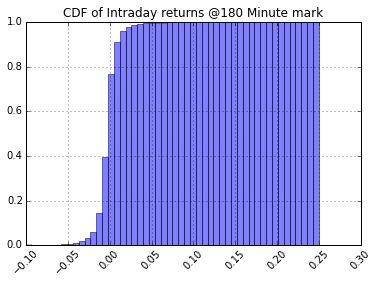

In [25]:
x = rets.loc['Ret_180']
rets.loc['Ret_180'].hist(bins=50,alpha=0.5,xrot=45,normed=True,cumulative=True,range=(-0.1,0.25));
plt.title('CDF of Intraday returns @180 Minute mark');
pd.DataFrame( { 'means' : np.mean(x),  'std' : np.std(x),  'LOGmeans' : np.mean(np.log(1+x)),  'LOGstd' : np.std(np.log(1+x) ) } , index=['0'])

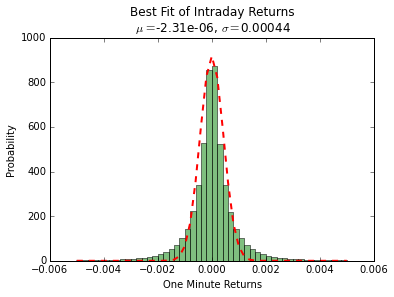

In [155]:
iret = Ret_Intraday.as_matrix().flatten()
iret = iret[~np.isnan(iret)]
#fig, ax = plt.subplots()
#ax.hist(iret, alpha=0.5, color='blue',range=(-0.005,0.005),bins=50,normed=True);

mu = np.mean(iret)  # mean of distribution
##why better fit for sigma/2.5????
sigma = np.std(iret)/2.5   # standard deviation of distribution
x = mu + sigma * np.random.randn(1000000)

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(iret, num_bins, normed=True, facecolor='green', alpha=0.5, range=(-0.005,0.005))
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2)
plt.xlabel('One Minute Returns')
plt.ylabel('Probability')
plt.title('Best Fit of Intraday Returns\n $\mu=$'+str(np.round(mu,8))+', ' +'$\sigma=$'+str(np.round(sigma,5)))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()



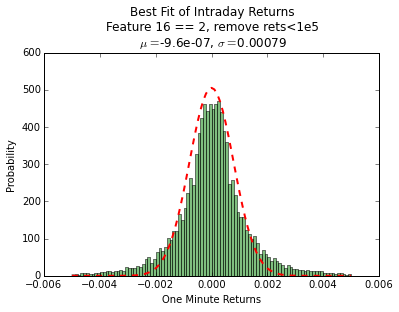

In [157]:
iret = Ret_Intraday[features['Feature_16']==2].as_matrix().flatten()
iret = iret[~np.isnan(iret)]
iret = iret[abs(iret)>0.00001]
fig, ax = plt.subplots()
#ax.hist(iret, alpha=0.5, color='blue',range=(-0.005,0.005),bins=100,normed=True);

mu = np.mean(iret)  # mean of distribution
##why better fit for sigma/4????
sigma = np.std(iret)/4   # standard deviation of distribution
x = mu + sigma * np.random.randn(10000)

num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(iret, num_bins, normed=True, facecolor='green', alpha=0.5, range=(-0.005,0.005));
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2);
plt.xlabel('One Minute Returns')
plt.ylabel('Probability')
plt.title('Best Fit of Intraday Returns\nFeature 16 == 2, remove rets<1e5\n $\mu=$'+str(np.round(mu,8))+', ' +'$\sigma=$'+str(np.round(sigma,5)));



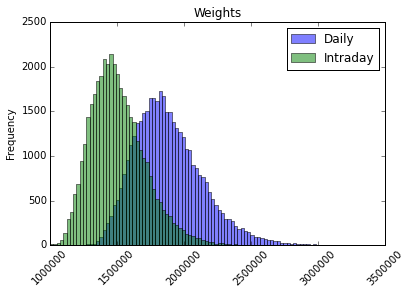

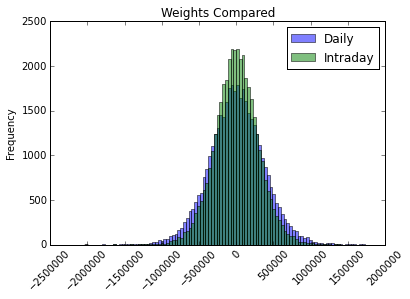

In [34]:
##Weights
##Note the close overlap
weights.plot(kind='hist',alpha=0.5,bins=100,rot=45,title='Weights');
weights.diff().plot(kind='hist',alpha=0.5, bins=100,title='Weights Compared',rot=45);



### Test Set Data fields

```60,000 rows by 147 columns with 25 features, 120 one minutes returns, 2 daily returns```

* **Feature_1 to Feature_25**: different features relevant to prediction
* **Ret_MinusTwo**:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
* **Ret_MinusOne**: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
* **Ret_2 to Ret_120**: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 


In [35]:
##Now for the test set
test  = pd.read_csv('C:/Users/sth/Downloads/test.csv/test.csv')
features, dailyReturns, weights, Ret_Intraday = data(test)
pd.set_option('display.max_columns', 25)
features.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
count,10408.000000,46336.000000,58120.000000,48351.000000,60000.000000,56967.000000,60000.000000,59291.000000,57122.000000,30514.000000,58576.000000,58320.000000,59094.000000,58906.000000,56776.000000,59018.000000,59083.000000,59167.000000,58264.000000,48449.000000,58445.000000,58073.000000,57346.000000,58866.000000,58973.000000
mean,3.424769,-0.110810,0.563854,0.406253,5.467933,0.440960,50493.118167,0.196795,10.688176,4.746772,-0.576302,0.498136,4.169527,1.590378,3.914202,1.006574,-0.562659,0.814596,-1.215980,5.199282,0.614198,-0.789846,0.796786,-1.215253,-0.333173
std,2.750073,1.243198,0.899474,0.796260,2.939668,1.514588,28962.488789,0.139005,2.887623,0.862946,1.241627,0.351856,2.594843,0.311673,5.049451,0.080816,0.906976,1.157447,0.640141,2.551019,1.326262,1.384089,1.304412,1.743079,0.954136
min,1.000000,-3.322407,-4.383210,-5.380588,1.000000,-0.942462,26.000000,0.009800,0.000000,1.000000,-7.344034,0.000000,0.000000,-0.260799,0.021679,1.000000,-2.567244,-6.918590,-3.263785,2.000000,-1.660691,-5.871376,-7.311352,-11.448255,-2.034658
25%,1.000000,-0.968250,-0.105866,-0.115252,2.000000,-0.261385,25578.000000,0.016600,9.000000,5.000000,-1.131707,0.150000,2.000000,1.416741,0.340230,1.000000,-1.018269,0.065239,-1.629251,3.000000,-0.294324,-1.800844,0.541919,-1.865978,-0.833147
50%,2.000000,-0.378556,0.443782,0.408238,6.000000,0.055084,50268.000000,0.213800,11.000000,5.000000,-0.322434,0.500000,4.000000,1.613841,1.303254,1.000000,-0.609589,0.599667,-1.180873,5.000000,0.314223,-0.713507,0.971900,-0.883600,-0.556804
75%,5.000000,0.420339,1.079343,0.948952,8.000000,0.564322,74964.750000,0.331800,12.000000,5.000000,0.320569,0.850000,6.000000,1.785382,6.381363,1.000000,-0.191342,1.319499,-0.750672,7.000000,1.119951,0.257671,1.418882,-0.127732,-0.260401
max,10.000000,4.232618,4.480979,2.880382,10.000000,12.605505,99989.000000,0.365000,36.000000,6.000000,2.473456,1.000000,9.000000,3.118524,28.018114,2.000000,8.040633,6.385551,0.928548,10.000000,7.840379,2.317160,3.305741,2.578119,3.955986


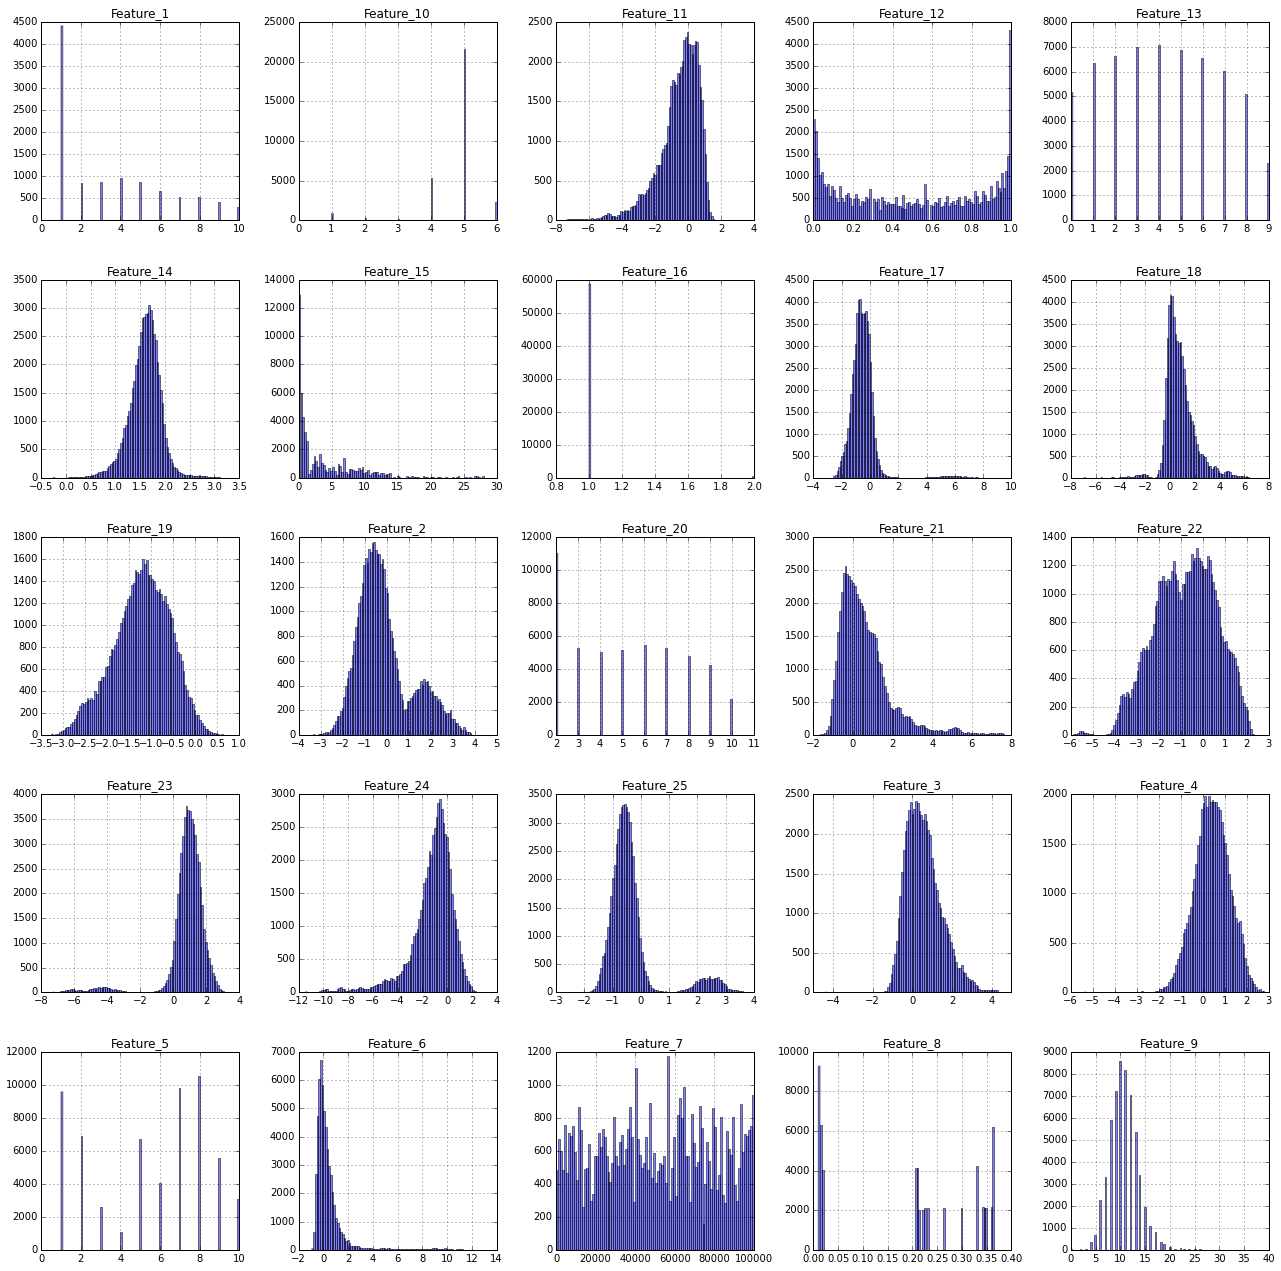

In [36]:
features.hist(alpha=0.5, bins=100,figsize=(22,22));

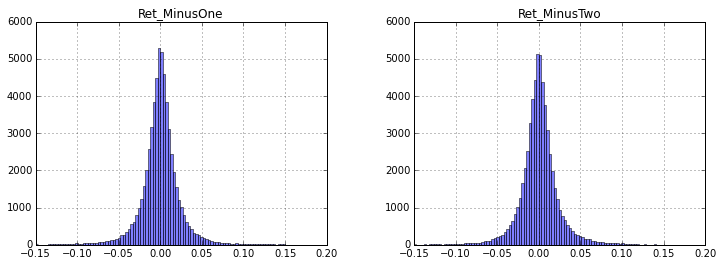

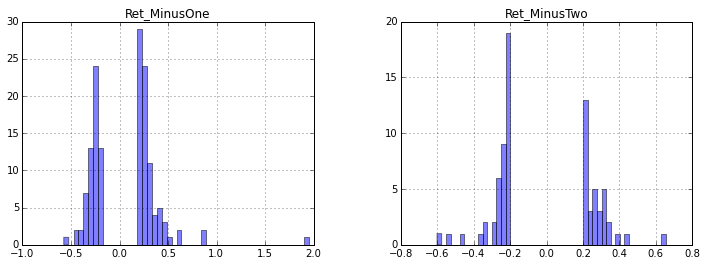

In [41]:
dailyReturns.hist(alpha=0.5, bins=100, range=(-0.15,0.15),figsize=(12,4));
dailyReturns[abs(dailyReturns)>0.2].hist(alpha=0.5,bins=50,figsize=(12,4));

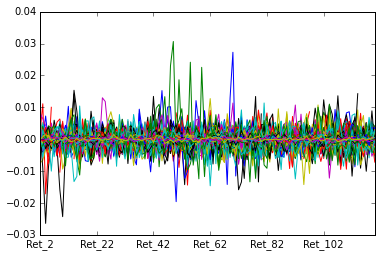

In [42]:
Ret_Intraday.iloc[0:1000,:].transpose().plot(legend=None)

### Actual Returns

Using google we can extract one minute bars for most liquid US stocks (about 3000).  Here we assume the extraction, which takes a few minutes.

In [310]:
#bars = pd.read_csv('C:/SciAdv/dev/data/googleBars.csv',header=None,sep="\t",parse_dates=[0,2])
bars.columns = ['datetime1','symbol','datetime','open','high','low','close','volume']
bars = bars[['symbol','datetime','close','volume']]

In [ ]:
bars = pd.read_csv('C:/SciAdv/dev/data/closeBars.txt',header=None,sep="\t",parse_dates=[1])
bars.columns = ['symbol','datetime','close']
bars = bars.set_index(['symbol','datetime'])
bars

In [ ]:
volume = pd.read_csv('C:/SciAdv/dev/data/volumeBars.txt',header=None,sep="\t",parse_dates=[1])
volume.columns = ['symbol','datetime','volume']
volume = volume.set_index(['symbol','datetime'])
volume

In [ ]:
dvol = pd.read_csv('C:/SciAdv/dev/data/dvolBars.txt',header=None,sep="\t",parse_dates=[1])
dvol.columns = ['symbol','datetime','dvol']
dvol = dvol.set_index(['symbol','datetime'])
dvol

In [61]:
#bars.min(axis=1,level='datetime')
print (bars.reset_index(level=1).sort_values(by="datetime").groupby(level=0).first()).min(axis=0)
print (bars.reset_index(level=1).sort_values(by="datetime").groupby(level=0).first()).max(axis=0)

datetime    2015-08-18 14:36:00
close                    0.2573
dtype: object
datetime    2015-09-01 13:46:00
close                   1564.59
dtype: object


In [178]:
volume  =  volume.unstack(level=0)
dvol       =  dvol.unstack(level=0)

In [159]:
calc_returns = lambda x: np.log(x / x.shift(1))[1:]
log_returns = close.apply(calc_returns)
#log_returns

calc_returns = lambda x: (x / x.shift(1)-1)[1:]
returns = close.apply(calc_returns)
#returns

In [160]:
##returns all times at beginning of day
#log_returns.between_time('13:30','13:30')
##to select only times between 13:31 and 20:00
log_returns =  log_returns.between_time('13:31','20:00')
returns        =  returns.between_time('13:31','20:00')


#### Comparison Winton Returns to Google Intraday Bars

Below we used both the log and percent returns and looked at the resulting distribution along with a fit to a normal distribution.  Compare this chart with the one above using the Winton returns.  Note that the occurence of -0- is far higher in the stock returns from google than in the contest.  ALso, NaN's from the beginning of day.  We used roughly the same number of returns (40000x180 = 7.2M Vs 19M from 5408 stocks × 3544 datetimes).

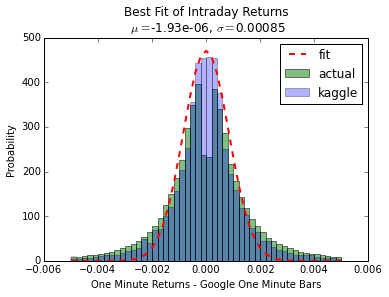

In [175]:
#iret = log_returns.as_matrix().flatten()
dret = returns.as_matrix().flatten()
dret = dret[~np.isnan(dret)]
dret = dret[abs(dret)>0.000001]
#fig, ax = plt.subplots()
#ax.hist(iret, alpha=0.5, color='blue',range=(-0.005,0.005),bins=50,normed=True);

mu = np.mean(dret)  # mean of distribution
##why better fit for sigma/2.0????
sigma = np.std(dret)/3.   # standard deviation of distribution
x = mu + sigma * np.random.randn(1000000)

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(dret, num_bins, normed=True, facecolor='green', alpha=0.5, range=(-0.005,0.005))
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2)

plt.hist(iret, num_bins, normed=True, facecolor='blue', alpha=0.3, range=(-0.005,0.005));

plt.xlabel('One Minute Returns - Google One Minute Bars')
plt.ylabel('Probability')
plt.legend(['fit','actual','kaggle'])
plt.title('Best Fit of Intraday Returns\n $\mu=$'+str(np.round(mu,8))+', ' +'$\sigma=$'+str(np.round(sigma,5)))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

#### Intraday dollar volumes
took the closing price for each one minute bar, multiplied by its volume and that gives a one minute dollar volume
fitted it (almost!) to a normal distribution

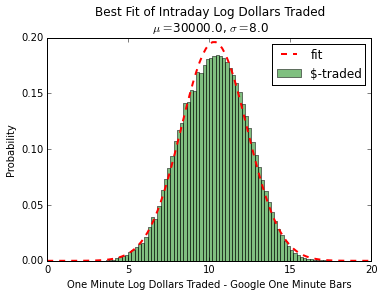

In [243]:
ddvol = dvol.as_matrix().flatten()
ddvol = np.log(1+ddvol)
ddvol = ddvol[~np.isnan(ddvol)]
fig, ax = plt.subplots()
#ax.hist(ddvol, alpha=0.5, color='blue',bins=50);

mu = np.mean(ddvol)  # mean of distribution
sigma = np.std(ddvol)   # standard deviation of distribution
x = mu + sigma * np.random.randn(10000)

num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(ddvol, num_bins,facecolor='green', normed=True,alpha=0.5,range=(0,20))
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--',linewidth=2)

plt.xlabel('One Minute Log Dollars Traded - Google One Minute Bars')
plt.ylabel('Probability')
plt.legend(['fit','$-traded'])
plt.title('Best Fit of Intraday Log Dollars Traded\n $\mu=$'+str(np.round(np.exp(mu),-3))+', ' +'$\sigma=$'+str(np.round(np.exp(sigma),0)))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [290]:
times = pd.DatetimeIndex(dvol.index)
grouped = dvol.groupby([times.hour, times.minute])
#grouped = dvol.groupby([times.hour,pd.Grouper(freq='30T')])

In [320]:
import datetime as dt
pd.date_range('13:30:00','20:00:00',freq='30T')

DatetimeIndex(['2015-11-09 13:30:00', '2015-11-09 14:00:00',
               '2015-11-09 14:30:00', '2015-11-09 15:00:00',
               '2015-11-09 15:30:00', '2015-11-09 16:00:00',
               '2015-11-09 16:30:00', '2015-11-09 17:00:00',
               '2015-11-09 17:30:00', '2015-11-09 18:00:00',
               '2015-11-09 18:30:00', '2015-11-09 19:00:00',
               '2015-11-09 19:30:00', '2015-11-09 20:00:00'],
              dtype='datetime64[ns]', freq='30T')

#### Feature 12 looks like the Liquidity Smile

Below is a binning by minute of dollars traded using actual google bars of dollar volume.  Notice the charactistic liquidity smile. 

This is similar to Feature 12, but F12 is by stock (40,000 obs in train set) with x-axis normalized between 0-1.0 and y-axis the number of stocks in that bin.  Here, the x-axis is time during the trading day (over 20 trading days) in one minute increments and the y-axis is the dollars traded during that time.

Hmmm.....

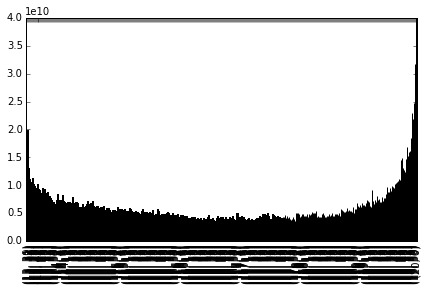

In [322]:
ax = plt.figure(figsize=(7,4), dpi=300).add_subplot(111)
xticks = pd.date_range('13:30:00','20:00:00',freq='30T')
ax.set_xticklabels([x.strftime('%H\n%M\n') for x in xticks]);
# set the text of the first few minor ticks created by pandas.plot
#    ax2.set_xticklabels(['a','b','c','d','e'], minor=True)
# remove the minor xtick labels set by pandas.plot 
##ax.set_xticklabels([], minor=True)
# turn the minor ticks created by pandas.plot off 
(grouped.sum()).sum(axis=1).plot(kind='bar',legend=None,ylim=(0,4e10),ax=ax)

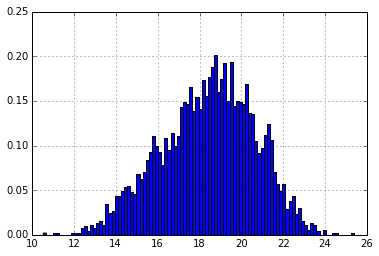

In [341]:
(np.log(dvol.sum())).hist(bins=100,normed=True)

In [350]:
gics = pd.read_csv('C:/SciAdv/dev/data/gics_sp500.txt',header=None,sep="\t")
gics.columns = ['symbol','sector']
cnts = gics.groupby('sector').count()

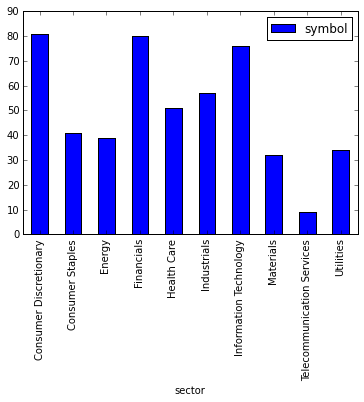

In [380]:
plt.suptitle("Feature 5 - Sectors",fontsize=14);
cnts.plot(kind='bar');

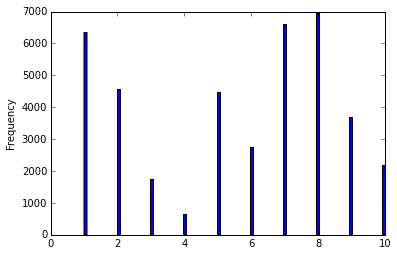

In [366]:
features['Feature_5'].plot(kind='hist',bins=100);

#### Patterns in daily returns by Sector (Feature 5)

Notice that Sector 1 Minus Two day returns have greatest numbr of outliers and again in days Plus one and Plus Two.

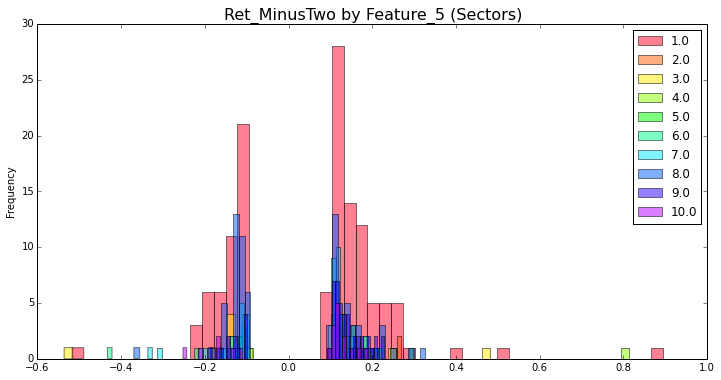

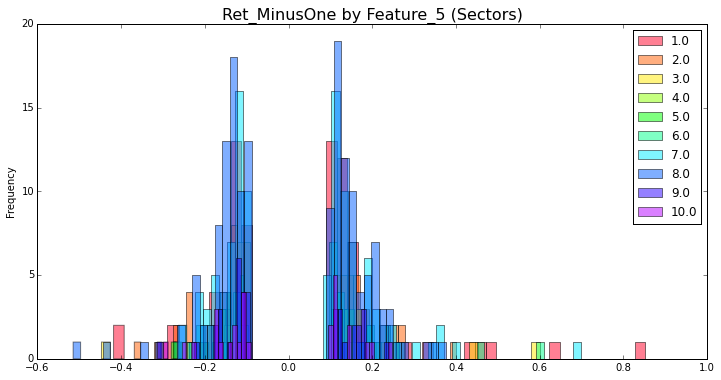

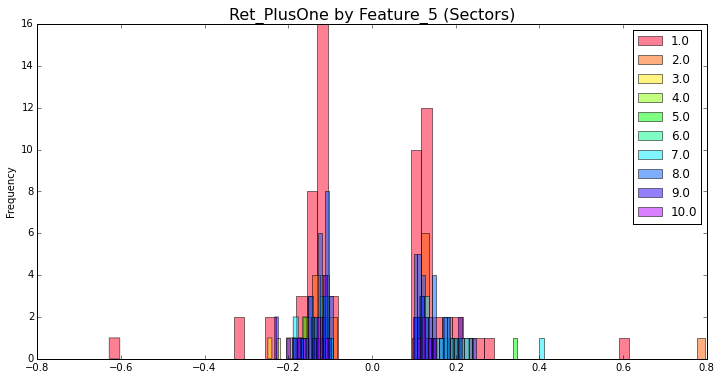

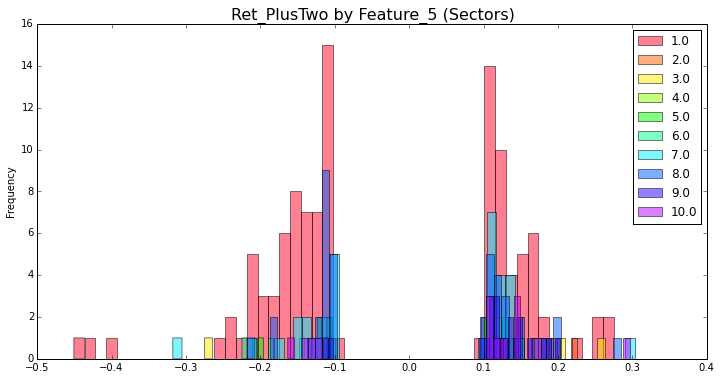

In [523]:
from matplotlib import cm

NUM_COLORS=10
cm = plt.get_cmap('gist_rainbow')

for stat in ['Ret_MinusTwo','Ret_MinusOne','Ret_PlusOne','Ret_PlusTwo']:
    fig, ax = plt.subplots()
    ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    groups = train.groupby("Feature_5")[stat]
    for v in groups:
        k = str(v[0])
        v[1][abs(v[1])>0.1].plot(kind='hist',label=k,alpha=.5, bins=50, ax=ax,figsize=(12,6));#,colormap='prism');
        #v[1].plot(kind='hist',label=k,alpha=.5, bins=50, ax=ax,figsize=(12,6),range=(-0.2,.2));#,colormap='prism');

    plt.title(stat +' by Feature_5 (Sectors)',fontsize=16)
    ax.legend()

In [ ]:
#train[['Feature_1','Feature_5','Feature_8','Feature_10','Feature_13','Feature_20']].plot(kind='bar')
cnts = train.groupby(['Feature_1','Feature_5','Feature_8','Feature_10','Feature_13','Feature_20']).size().reset_index()[[0]]
cnts

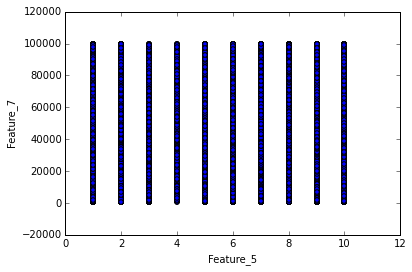

In [551]:
#features['Feature_7'].sort_values().plot(kind='scatter')
features.plot(kind='scatter',x='Feature_5',y='Feature_7')

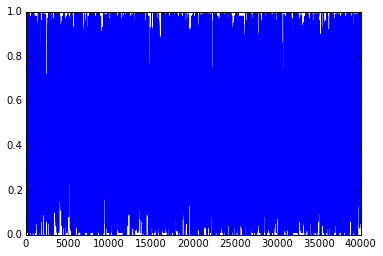

In [578]:
features['Feature_12'][features['Feature_5']==2].plot()

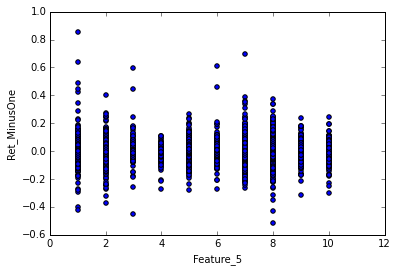

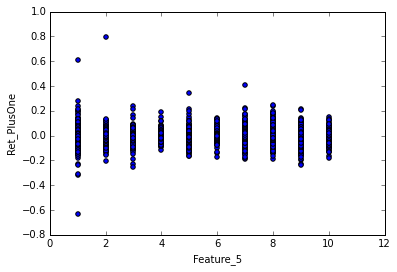

In [570]:
train.plot(kind='scatter',x='Feature_5',y='Ret_MinusOne')
train.plot(kind='scatter',x='Feature_5',y='Ret_PlusOne')

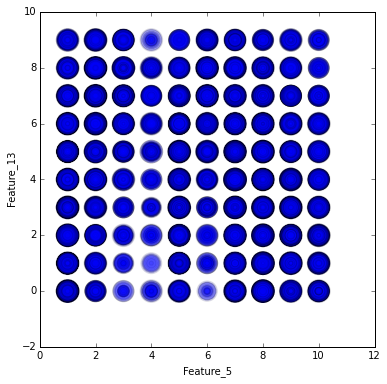

In [687]:
##Interesting!!!!
##Feature 5 is Sector
##What is Feature 13?
cnts = train.groupby(['Feature_5','Feature_13']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_5',y='Feature_13',s=cnts.values/2,figsize=(6,6),alpha=0.1);#,xlim=(0.95,1.05),ylim=(-0.05,0.05))

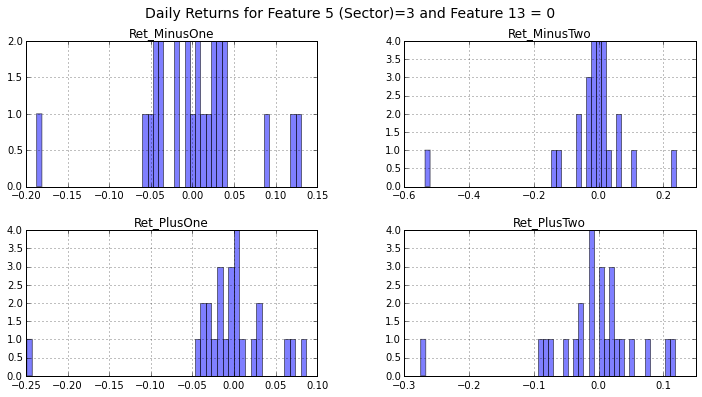

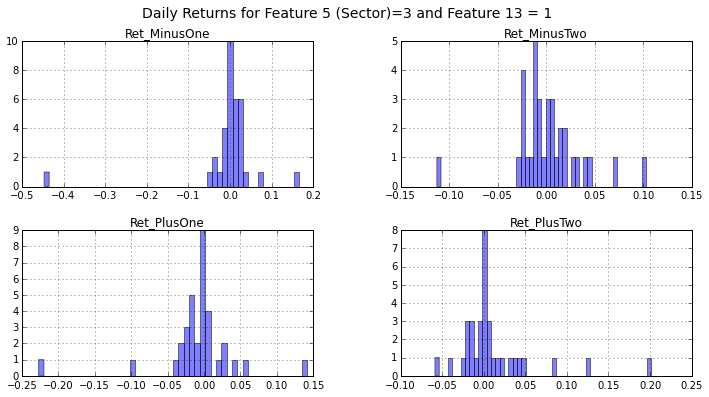

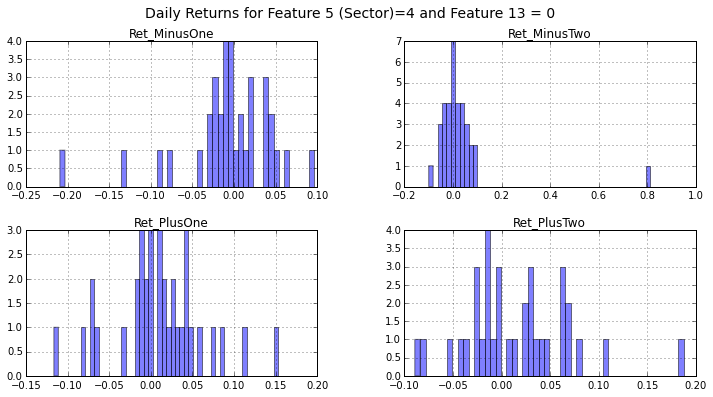

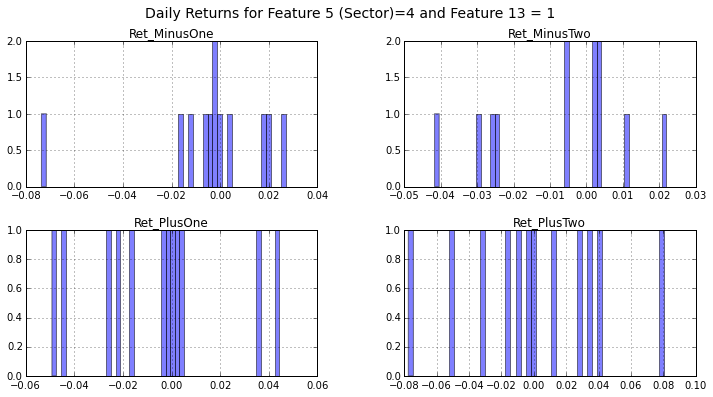

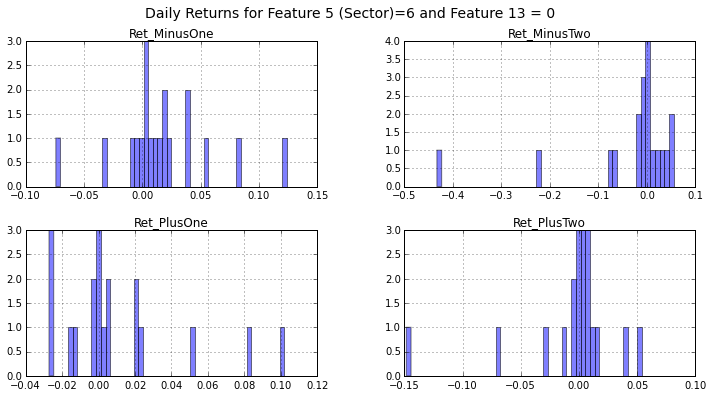

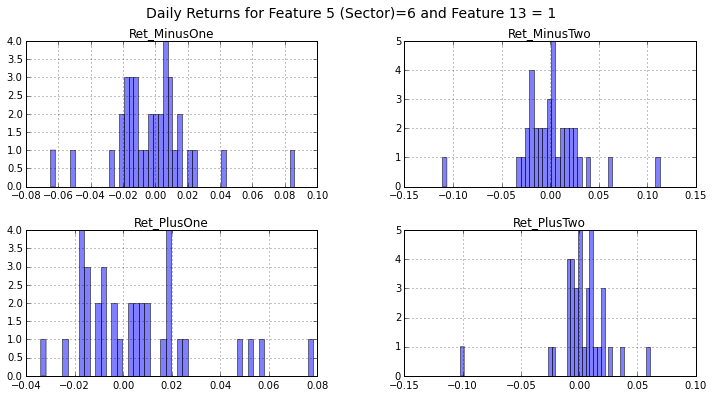

In [688]:
#for i in range(1,11):
#    for j in range(10):
for i in [3,4,6]:
    for j in [0,1]:
        dailyReturns[(features['Feature_5'] == i) & (features['Feature_13'] ==j)].hist(bins=50,alpha=0.5,figsize=(12,6));
        plt.suptitle("Daily Returns for Feature 5 (Sector)="+str(i)+" and Feature 13 = "+str(j),fontsize=14);


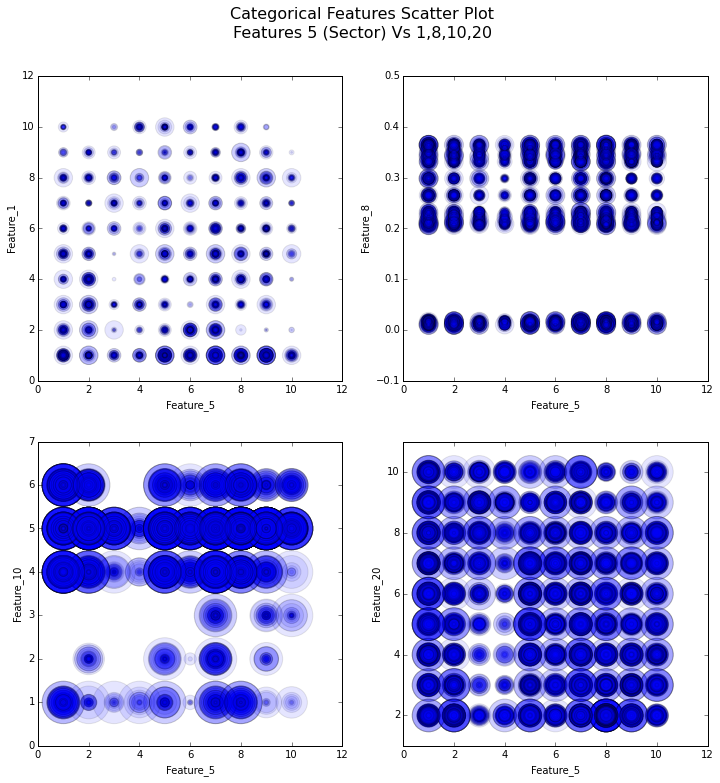

In [692]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
plt.suptitle("Categorical Features Scatter Plot\nFeatures 5 (Sector) Vs 1,8,10,20",fontsize=16);

cnts = train.groupby(['Feature_5','Feature_1']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_5',y='Feature_1',s=cnts.values/2,alpha=0.1,ax=axes[0,0]);

cnts = train.groupby(['Feature_5','Feature_8']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_5',y='Feature_8',s=cnts.values/2,alpha=0.1,ax=axes[0,1]);

cnts = train.groupby(['Feature_5','Feature_10']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_5',y='Feature_10',s=cnts.values/2,alpha=0.1,ax=axes[1,0]);

cnts = train.groupby(['Feature_5','Feature_20']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_5',y='Feature_20',s=cnts.values/2,alpha=0.1,ax=axes[1,1]);

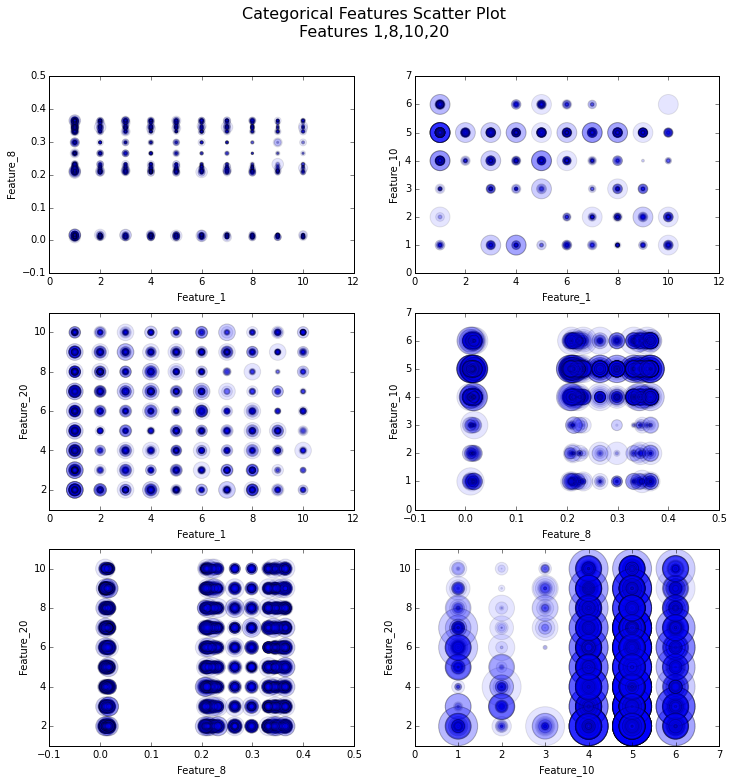

In [693]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,12))
plt.suptitle("Categorical Features Scatter Plot\nFeatures 1,8,10,20",fontsize=16);

cnts = train.groupby(['Feature_1','Feature_8']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_1',y='Feature_8',s=cnts.values/2,ax=axes[0,0],alpha=0.1);

cnts = train.groupby(['Feature_1','Feature_10']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_1',y='Feature_10',s=cnts.values/2,ax=axes[0,1],alpha=0.1);

cnts = train.groupby(['Feature_1','Feature_20']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_1',y='Feature_20',s=cnts.values/2,ax=axes[1,0],alpha=0.1);

cnts = train.groupby(['Feature_8','Feature_10']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_8',y='Feature_10',s=cnts.values/2,ax=axes[1,1],alpha=0.1);

cnts = train.groupby(['Feature_8','Feature_20']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_8',y='Feature_20',s=cnts.values/2,ax=axes[2,0],alpha=0.1);

cnts = train.groupby(['Feature_10','Feature_20']).size().reset_index()[[0]]
train.plot(kind='scatter',x='Feature_10',y='Feature_20',s=cnts.values/2,ax=axes[2,1],alpha=0.1);